In [1]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset 

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 25.67 MiB/s, done.


In [2]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
print(gpu)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import sys
sys.path.append('/kaggle/working/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

#  Setting Data paths and visualizing dataset

In [5]:
d_dir='/kaggle/working/Person-Re-Id-Dataset/train/'
csv='/kaggle/working/Person-Re-Id-Dataset/train.csv'
batch_sz=128
learning_rate=0.001
epochs=400
device='cuda'

In [6]:
df=pd.read_csv(csv)
df.head(7)

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg
5,0663_c6s4_011877_01.jpg,0354_c6s1_081151_02.jpg,0663_c3s3_085469_02.jpg
6,0663_c1s6_036721_09.jpg,0151_c1s1_025076_01.jpg,0663_c6s4_011902_01.jpg


In [7]:
row=df.iloc[18]

A_img=io.imread(d_dir + row.Anchor)
N_img=io.imread(d_dir+row.Negative)
P_img=io.imread(d_dir+row.Positive)

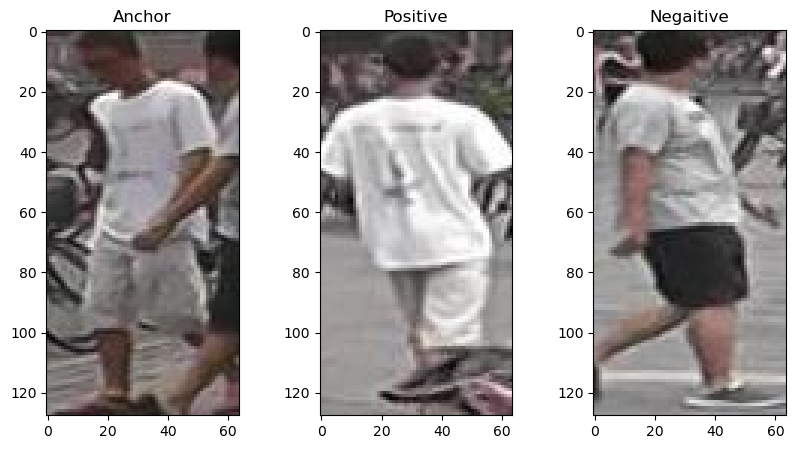

In [8]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negaitive')
ax3.imshow(N_img)

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=45)

# Creating APN Dataset

In [10]:
class APN_Dataset(Dataset):
    
    def __init__(self,df):
        self.df=df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row=self.df.iloc[idx]
        A_img=io.imread(d_dir + row.Anchor)
        N_img=io.imread(d_dir+row.Negative)
        P_img=io.imread(d_dir+row.Positive)
        
        A_img=torch.from_numpy(A_img).permute(2,0,1)/255.0
        P_img=torch.from_numpy(P_img).permute(2,0,1)/255.0
        N_img=torch.from_numpy(N_img).permute(2,0,1)/255.0
        
        return A_img, P_img, N_img

In [11]:
train=APN_Dataset(train_df)
valid=APN_Dataset(valid_df)

print(f"train set length: {len(train)}")
print(f"valid set length: {len(valid)}")

train set length: 3200
valid set length: 800


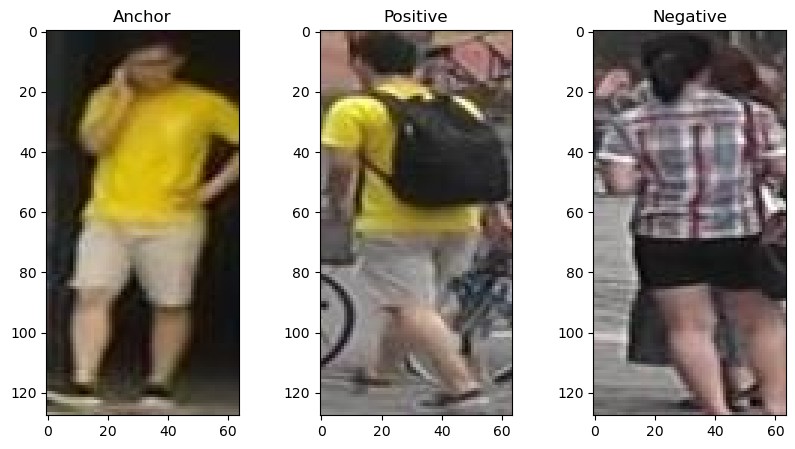

In [12]:
idx=47
A,P,N=train[idx]

f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)),cmap='gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)),cmap='gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)),cmap='gray')

# Loading dataset into batches

In [13]:
trainLoad=DataLoader(train,batch_size=batch_sz,shuffle=True)
validLoad=DataLoader(valid,batch_size=batch_sz)

In [14]:
print(f"No of batches in trainLoad {len(trainLoad)}")
print(f"No of batches in validLoad {len(validLoad)}")

No of batches in trainLoad 25
No of batches in validLoad 7


In [15]:
for A,P,N in trainLoad:
    break
print(f"One image batch shape: {A.shape}")

One image batch shape: torch.Size([128, 3, 128, 64])


# Creating Model

In [16]:
class APN_Model(nn.Module):
    def __init__(self,emb_size=512):
        super(APN_Model,self).__init__()
        
        self.efficientnet=timm.create_model('efficientnet_b0',pretrained=True)
        self.efficientnet.classifier=nn.Linear(in_features=self.efficientnet.classifier.in_features,out_features=emb_size)
        
    def forward(self,image):
        embeddings=self.efficientnet(image)
        
        return embeddings

In [17]:
model=APN_Model(1024)
model.to(device)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

In [18]:
def train_model(model,dataloader,optimizer,criterion):
    model.train() # Turn on Dropout
    total_loss=0.0
    
    for A,P,N in tqdm(dataloader):
        A,P,N=A.to(device),P.to(device),N.to(device)
        
        A_embs=model(A)
        P_embs=model(P)
        N_embs=model(N)
        
        loss=criterion(A_embs,P_embs,N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        
    return total_loss/len(dataloader)

In [19]:
def eval_model(model,dataloader,criterion):
    model.eval() # Turn off Dropout
    total_loss=0.0
    
    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N=A.to(device),P.to(device),N.to(device)

            A_embs=model(A)
            P_embs=model(P)
            N_embs=model(N)

            loss=criterion(A_embs,P_embs,N_embs)

            total_loss+=loss.item()
        
        return total_loss/len(dataloader)

**Declaring loss functions and optimizers**

In [20]:
criterion=nn.TripletMarginLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

**Training**

In [21]:
best_valid_loss=np.Inf
train_losses,valid_losses=[],[]
for i in range(epochs):
    train_loss=train_model(model,trainLoad,optimizer,criterion)
    valid_loss=eval_model(model,validLoad,criterion)
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt') #save
        best_valid_loss=valid_loss
        print('Saved weights success')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"epoch: {i+1}  train_loss: {train_loss}  valid_loss: {valid_loss}")

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Saved weights success
epoch: 1  train_loss: 0.7317098832130432  valid_loss: 0.5889541634491512


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Saved weights success
epoch: 2  train_loss: 0.19556910693645477  valid_loss: 0.3690410426684788


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Saved weights success
epoch: 3  train_loss: 0.07846493780612945  valid_loss: 0.3090989759990147


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 4  train_loss: 0.04340602248907089  valid_loss: 0.3112704711300986


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Saved weights success
epoch: 5  train_loss: 0.04425378441810608  valid_loss: 0.2258062128509794


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Saved weights success
epoch: 6  train_loss: 0.027448288202285766  valid_loss: 0.21242111389126098


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


epoch: 7  train_loss: 0.015415508151054382  valid_loss: 0.22899298157010758


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 8  train_loss: 0.005987918376922608  valid_loss: 0.2753722071647644


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Saved weights success
epoch: 9  train_loss: 0.010638880878686904  valid_loss: 0.20794835686683655


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 10  train_loss: 0.015274852365255356  valid_loss: 0.24718345275947026


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


epoch: 11  train_loss: 0.01299693614244461  valid_loss: 0.3326240565095629


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 12  train_loss: 0.021989110857248306  valid_loss: 0.3345075398683548


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


epoch: 13  train_loss: 0.0223662993311882  valid_loss: 0.3107786348887852


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 14  train_loss: 0.0817421555519104  valid_loss: 0.27159024349280764


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


epoch: 15  train_loss: 0.0788235068321228  valid_loss: 0.40564211564404623


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


epoch: 16  train_loss: 0.08367826640605927  valid_loss: 0.3700201522026743


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


epoch: 17  train_loss: 0.04938407659530639  valid_loss: 0.23912436408655985


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


epoch: 18  train_loss: 0.039524368941783905  valid_loss: 0.21710378038031714


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


epoch: 19  train_loss: 0.031237701028585432  valid_loss: 0.32497598975896835


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 20  train_loss: 0.034346941709518436  valid_loss: 0.2697631972176688


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


epoch: 21  train_loss: 0.043374386578798295  valid_loss: 0.2585571323122297


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 22  train_loss: 0.02867795616388321  valid_loss: 0.2168073228427342


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


epoch: 23  train_loss: 0.018968563228845596  valid_loss: 0.21272557548114232


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Saved weights success
epoch: 24  train_loss: 0.011968909204006195  valid_loss: 0.17539258939879282


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Saved weights success
epoch: 25  train_loss: 0.0050804330408573154  valid_loss: 0.13266178326947348


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 26  train_loss: 0.0021934914588928223  valid_loss: 0.17523094692400523


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


epoch: 27  train_loss: 0.0006727012991905213  valid_loss: 0.18703724603567803


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 28  train_loss: 0.0014239838719367981  valid_loss: 0.18807257818324224


100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


epoch: 29  train_loss: 0.0025976458191871643  valid_loss: 0.18257526734045573


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 30  train_loss: 0.0  valid_loss: 0.17616099012749536


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


epoch: 31  train_loss: 0.0018473026156425477  valid_loss: 0.18989238355840957


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 32  train_loss: 0.0011699873208999634  valid_loss: 0.18659022450447083


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


epoch: 33  train_loss: 0.0001164206862449646  valid_loss: 0.18338911022458756


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


epoch: 34  train_loss: 0.00010195791721343994  valid_loss: 0.18922065304858343


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


epoch: 35  train_loss: 0.00030609190464019775  valid_loss: 0.18719734677246638


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


epoch: 36  train_loss: 0.0002062225341796875  valid_loss: 0.1661137810775212


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


epoch: 37  train_loss: 0.00027816057205200197  valid_loss: 0.15769330944333756


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 38  train_loss: 0.0010249583423137664  valid_loss: 0.17426525056362152


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


epoch: 39  train_loss: 0.004815026968717575  valid_loss: 0.19409474836928503


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 40  train_loss: 0.0014227324724197389  valid_loss: 0.19038574610437667


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


epoch: 41  train_loss: 0.0017510828375816344  valid_loss: 0.20658223863158906


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 42  train_loss: 0.005608623325824738  valid_loss: 0.18875546008348465


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


epoch: 43  train_loss: 0.006250665783882141  valid_loss: 0.20170140798602784


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 44  train_loss: 0.01286555826663971  valid_loss: 0.15275076244558608


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


epoch: 45  train_loss: 0.007497393041849137  valid_loss: 0.18466904014348984


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 46  train_loss: 0.012578264772891999  valid_loss: 0.19078065029212407


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


epoch: 47  train_loss: 0.02222037494182587  valid_loss: 0.1990380042365619


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 48  train_loss: 0.00889095276594162  valid_loss: 0.24827628476279123


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


epoch: 49  train_loss: 0.023463284373283388  valid_loss: 0.1882976410644395


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 50  train_loss: 0.034867163896560666  valid_loss: 0.2522719459874289


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


epoch: 51  train_loss: 0.05251184672117233  valid_loss: 0.2203595308320863


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 52  train_loss: 0.025499870330095292  valid_loss: 0.22896619034664972


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


epoch: 53  train_loss: 0.039038553386926654  valid_loss: 0.2678376180785043


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 54  train_loss: 0.038332060426473615  valid_loss: 0.21272113919258118


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


epoch: 55  train_loss: 0.016470328569412232  valid_loss: 0.2413601694362504


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 56  train_loss: 0.014119355380535126  valid_loss: 0.2535331201340471


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


epoch: 57  train_loss: 0.012925110161304473  valid_loss: 0.19624186200754984


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 58  train_loss: 0.009106305241584779  valid_loss: 0.2081618101469108


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


epoch: 59  train_loss: 0.0026635311543941496  valid_loss: 0.23566038480826787


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 60  train_loss: 0.005064726769924164  valid_loss: 0.2175560268972601


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


epoch: 61  train_loss: 0.0031044602394104002  valid_loss: 0.185648646737848


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 62  train_loss: 0.0008008107542991638  valid_loss: 0.20047445382390702


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


epoch: 63  train_loss: 0.0002507537603378296  valid_loss: 0.22013250419071742


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 64  train_loss: 0.00032663792371749877  valid_loss: 0.22528678817408426


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


epoch: 65  train_loss: 4.2886435985565185e-05  valid_loss: 0.19958260442529405


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 66  train_loss: 0.0  valid_loss: 0.2118061344538416


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 67  train_loss: 0.0  valid_loss: 0.19959820913416998


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 68  train_loss: 0.0  valid_loss: 0.20025513108287538


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 69  train_loss: 0.0  valid_loss: 0.2301844965134348


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 70  train_loss: 0.0  valid_loss: 0.2057079885687147


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 71  train_loss: 0.0  valid_loss: 0.19008577881114824


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 72  train_loss: 0.0  valid_loss: 0.20548142812081746


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


epoch: 73  train_loss: 0.0  valid_loss: 0.20098954332726343


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 74  train_loss: 0.0  valid_loss: 0.19485961220094136


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 75  train_loss: 0.0  valid_loss: 0.19596298464706965


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 76  train_loss: 0.0  valid_loss: 0.19169626704284123


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 77  train_loss: 0.0005835443735122681  valid_loss: 0.21199246229869978


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 78  train_loss: 0.0  valid_loss: 0.20845673925110272


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


epoch: 79  train_loss: 3.3948719501495365e-05  valid_loss: 0.2107113003730774


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 80  train_loss: 0.0  valid_loss: 0.2118375604706151


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 81  train_loss: 0.0014209136366844176  valid_loss: 0.1929497266454356


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 82  train_loss: 0.0013403330743312835  valid_loss: 0.23153354866164072


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 83  train_loss: 0.003913310766220093  valid_loss: 0.2664747749056135


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 84  train_loss: 0.007102837264537812  valid_loss: 0.34997077605554033


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 85  train_loss: 0.015516513288021087  valid_loss: 0.27934810306344715


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 86  train_loss: 0.06165735587477684  valid_loss: 0.32270923256874084


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 87  train_loss: 0.059232202172279355  valid_loss: 0.19825310579368047


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 88  train_loss: 0.026278638541698457  valid_loss: 0.18628627913338797


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 89  train_loss: 0.005891288965940476  valid_loss: 0.319551808493478


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


epoch: 90  train_loss: 0.05228427976369858  valid_loss: 0.30159247134413036


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 91  train_loss: 0.022585268914699554  valid_loss: 0.34141490502016886


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


epoch: 92  train_loss: 0.05558273494243622  valid_loss: 0.22071661800146103


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 93  train_loss: 0.051525274813175204  valid_loss: 0.3117311011467661


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


epoch: 94  train_loss: 0.03418083354830742  valid_loss: 0.15389931521245412


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 95  train_loss: 0.015328033864498138  valid_loss: 0.19844906138522284


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


epoch: 96  train_loss: 0.045018130838871004  valid_loss: 0.17239850919161523


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 97  train_loss: 0.009411340802907944  valid_loss: 0.20810011454990932


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 98  train_loss: 0.011390376389026641  valid_loss: 0.21420803027493612


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


Saved weights success
epoch: 99  train_loss: 0.010530239939689635  valid_loss: 0.11541326237576348


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 100  train_loss: 0.005243596881628037  valid_loss: 0.17021894880703517


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 101  train_loss: 0.0016758948564529418  valid_loss: 0.13378422441227095


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 102  train_loss: 0.0008517545461654663  valid_loss: 0.1271732167473861


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 103  train_loss: 0.0  valid_loss: 0.13419132679700851


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 104  train_loss: 0.0013547083735466004  valid_loss: 0.17439852442060197


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 105  train_loss: 0.000900883674621582  valid_loss: 0.21162610075303487


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 106  train_loss: 0.006749361157417298  valid_loss: 0.22045330277511052


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 107  train_loss: 0.0024729260802268983  valid_loss: 0.18759027123451233


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 108  train_loss: 0.0062634629011154175  valid_loss: 0.1651029395205634


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 109  train_loss: 0.008636249899864197  valid_loss: 0.190970955150468


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 110  train_loss: 0.0013972151279449463  valid_loss: 0.21983564964362554


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 111  train_loss: 0.0016785511374473572  valid_loss: 0.20466157581124986


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 112  train_loss: 0.001038854420185089  valid_loss: 0.23011415558201925


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 113  train_loss: 0.0010820740461349487  valid_loss: 0.205088771879673


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 114  train_loss: 0.0  valid_loss: 0.18280833320958273


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 115  train_loss: 0.0011401143670082092  valid_loss: 0.16434283128806523


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 116  train_loss: 0.00025564759969711305  valid_loss: 0.17199757375887462


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 117  train_loss: 0.0  valid_loss: 0.20784337712185724


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 118  train_loss: 0.0018869675695896149  valid_loss: 0.15574605017900467


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 119  train_loss: 0.006755804419517517  valid_loss: 0.14992483918155944


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 120  train_loss: 0.003603622913360596  valid_loss: 0.15289488594446862


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 121  train_loss: 0.0019728973507881164  valid_loss: 0.14212878101638385


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 122  train_loss: 0.0001954805850982666  valid_loss: 0.17583457486970083


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 123  train_loss: 0.0  valid_loss: 0.18460394548518316


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 124  train_loss: 0.0004195761680603027  valid_loss: 0.18903198093175888


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 125  train_loss: 0.0  valid_loss: 0.21243385012660707


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 126  train_loss: 0.0009693604707717896  valid_loss: 0.18908606682504928


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 127  train_loss: 0.0  valid_loss: 0.19330649077892303


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 128  train_loss: 0.0003774183988571167  valid_loss: 0.18429253356797354


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 129  train_loss: 0.0  valid_loss: 0.18197771055357798


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 130  train_loss: 0.0  valid_loss: 0.18021158980471746


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


epoch: 131  train_loss: 0.00041711449623107913  valid_loss: 0.19379521001662528


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 132  train_loss: 0.0  valid_loss: 0.20077720656991005


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 133  train_loss: 0.0  valid_loss: 0.20654661368046487


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 134  train_loss: 0.0  valid_loss: 0.1971487126180104


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


epoch: 135  train_loss: 0.00046749860048294066  valid_loss: 0.19629000765936716


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 136  train_loss: 0.0  valid_loss: 0.16614879348448344


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


epoch: 137  train_loss: 0.0  valid_loss: 0.1625642968075616


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 138  train_loss: 0.0  valid_loss: 0.16954635669078147


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


epoch: 139  train_loss: 0.0  valid_loss: 0.1586664728820324


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


epoch: 140  train_loss: 0.0  valid_loss: 0.16773845893996103


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


epoch: 141  train_loss: 0.0  valid_loss: 0.16189781576395035


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 142  train_loss: 0.0006619277596473694  valid_loss: 0.17076568518366134


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 143  train_loss: 0.0002236834168434143  valid_loss: 0.19769724032708577


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 144  train_loss: 0.005817945003509521  valid_loss: 0.20007478977952683


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 145  train_loss: 0.013329079002141952  valid_loss: 0.24852920749357768


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 146  train_loss: 0.01522406354546547  valid_loss: 0.2887105814048222


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 147  train_loss: 0.043556803613901136  valid_loss: 0.2745759742600577


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 148  train_loss: 0.07575135231018067  valid_loss: 0.2545616924762726


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 149  train_loss: 0.07609523892402649  valid_loss: 0.2689993700810841


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 150  train_loss: 0.016798790842294693  valid_loss: 0.22856422407286509


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 151  train_loss: 0.014525949656963348  valid_loss: 0.2203259574515479


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 152  train_loss: 0.00024664580821990965  valid_loss: 0.26928028357880457


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 153  train_loss: 0.0012906545400619507  valid_loss: 0.2642101677400725


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 154  train_loss: 0.0010190320014953614  valid_loss: 0.21041952871850558


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 155  train_loss: 0.0015809854865074158  valid_loss: 0.1866907546562808


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 156  train_loss: 0.0  valid_loss: 0.21299138558762415


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 157  train_loss: 0.0  valid_loss: 0.2197373073015894


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 158  train_loss: 0.050672357827425005  valid_loss: 0.1831449759857995


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 159  train_loss: 0.028206512704491614  valid_loss: 0.3089622216565268


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 160  train_loss: 0.014332134276628494  valid_loss: 0.19265984743833542


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 161  train_loss: 0.002032681852579117  valid_loss: 0.20491621323994227


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 162  train_loss: 0.005604589581489563  valid_loss: 0.3121083506516048


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 163  train_loss: 0.0011843468248844146  valid_loss: 0.16802758404186793


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 164  train_loss: 0.00047790110111236574  valid_loss: 0.17766680355582917


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 165  train_loss: 0.0006822460889816284  valid_loss: 0.1816141073192869


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 166  train_loss: 0.002981109917163849  valid_loss: 0.215007628181151


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 167  train_loss: 0.021995186656713486  valid_loss: 0.2267190915133272


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 168  train_loss: 0.016080158799886703  valid_loss: 0.13863895301307952


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 169  train_loss: 0.004064251184463501  valid_loss: 0.16339825838804245


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 170  train_loss: 0.0034026393294334413  valid_loss: 0.15568432424749648


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 171  train_loss: 0.002874419242143631  valid_loss: 0.21320493199995585


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 172  train_loss: 0.0024603545665740968  valid_loss: 0.2511846444436482


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 173  train_loss: 0.0004759630560874939  valid_loss: 0.22974854707717896


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 174  train_loss: 0.000527096688747406  valid_loss: 0.1857888666646821


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 175  train_loss: 0.002533208131790161  valid_loss: 0.25522088578769137


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 176  train_loss: 0.002645575702190399  valid_loss: 0.17603063317281858


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 177  train_loss: 0.004622908234596252  valid_loss: 0.25016154668160845


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 178  train_loss: 0.0010645371675491334  valid_loss: 0.27931639764990124


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 179  train_loss: 0.005036037862300873  valid_loss: 0.2839664412396295


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 180  train_loss: 0.0045838353037834165  valid_loss: 0.28153147867747713


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 181  train_loss: 0.002859591543674469  valid_loss: 0.2625082688672202


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 182  train_loss: 0.002557412385940552  valid_loss: 0.18946521143828118


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 183  train_loss: 0.0023702728748321534  valid_loss: 0.25419449912650244


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 184  train_loss: 0.0  valid_loss: 0.179125400526183


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 185  train_loss: 0.0  valid_loss: 0.18479602304952486


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 186  train_loss: 0.0  valid_loss: 0.18615676994834626


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


epoch: 187  train_loss: 0.0  valid_loss: 0.20057432992117746


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 188  train_loss: 0.012024524360895157  valid_loss: 0.11798021889158658


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 189  train_loss: 0.0031340475380420684  valid_loss: 0.19859678936856134


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 190  train_loss: 0.00221655935049057  valid_loss: 0.1909090525337628


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 191  train_loss: 0.0017401999235153198  valid_loss: 0.30660790630749296


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


epoch: 192  train_loss: 0.005254968702793121  valid_loss: 0.2084700603570257


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 193  train_loss: 0.0047746899724006656  valid_loss: 0.1822251927639757


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


epoch: 194  train_loss: 0.0  valid_loss: 0.2114222619150366


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 195  train_loss: 0.0007851436734199524  valid_loss: 0.2367532817380769


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


epoch: 196  train_loss: 0.04551627725362778  valid_loss: 0.3001548115696226


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 197  train_loss: 0.1207591188699007  valid_loss: 0.24175391984837397


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


epoch: 198  train_loss: 0.04610712662339211  valid_loss: 0.1725946425327233


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 199  train_loss: 0.029479054808616637  valid_loss: 0.1594217031129769


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


epoch: 200  train_loss: 0.008831694722175598  valid_loss: 0.1768888458609581


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 201  train_loss: 0.0036151735484600067  valid_loss: 0.20978851084198272


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 202  train_loss: 0.002220706641674042  valid_loss: 0.21665093515600478


100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 203  train_loss: 0.0056321735680103305  valid_loss: 0.3555747057710375


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 204  train_loss: 0.014721889048814774  valid_loss: 0.20411005084003722


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 205  train_loss: 0.0053520694375038145  valid_loss: 0.2687121352979115


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 206  train_loss: 0.005990740954875946  valid_loss: 0.26893280552966253


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 207  train_loss: 0.04694842517375946  valid_loss: 0.36444698699883055


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 208  train_loss: 0.17209100648760794  valid_loss: 0.2216700634786061


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 209  train_loss: 0.0722939394414425  valid_loss: 0.1425955199769565


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 210  train_loss: 0.03095271110534668  valid_loss: 0.11703225012336459


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 211  train_loss: 0.005206276774406433  valid_loss: 0.13512378185987473


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 212  train_loss: 0.005077624171972275  valid_loss: 0.14047920810324804


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 213  train_loss: 0.00586264818906784  valid_loss: 0.1284931248852185


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 214  train_loss: 0.0014892058074474335  valid_loss: 0.12470577231475286


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 215  train_loss: 0.0014366389811038972  valid_loss: 0.12737745578799928


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 216  train_loss: 5.566775798797608e-05  valid_loss: 0.13710755854845047


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 217  train_loss: 0.002175808697938919  valid_loss: 0.12380704070840563


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Saved weights success
epoch: 218  train_loss: 0.0019946296513080595  valid_loss: 0.11215408412473542


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 219  train_loss: 0.00013189911842346192  valid_loss: 0.11653269880584308


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 220  train_loss: 0.0  valid_loss: 0.11661694624594279


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 221  train_loss: 0.0  valid_loss: 0.11326431004064423


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 222  train_loss: 0.00019870772957801818  valid_loss: 0.12236086811338152


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 223  train_loss: 0.0  valid_loss: 0.12507755841527665


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 224  train_loss: 0.00012454241514205932  valid_loss: 0.13914466755730764


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 225  train_loss: 0.001161363422870636  valid_loss: 0.12200240418314934


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 226  train_loss: 0.002531597316265106  valid_loss: 0.11829494365624019


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Saved weights success
epoch: 227  train_loss: 0.0003527919948101044  valid_loss: 0.10655678063631058


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 228  train_loss: 0.00011364817619323731  valid_loss: 0.11521208073411669


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 229  train_loss: 0.0  valid_loss: 0.12700766324996948


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 230  train_loss: 0.00043261826038360596  valid_loss: 0.14170849642583302


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 231  train_loss: 0.0  valid_loss: 0.14392270360674178


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 232  train_loss: 0.0005213925242424011  valid_loss: 0.14901706044163024


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 233  train_loss: 0.0  valid_loss: 0.15187413139002665


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 234  train_loss: 0.0001298469305038452  valid_loss: 0.15806858241558075


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 235  train_loss: 0.0007157482206821442  valid_loss: 0.13382754155567714


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 236  train_loss: 0.00016214102506637574  valid_loss: 0.12151740491390228


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 237  train_loss: 7.311820983886719e-05  valid_loss: 0.11595276743173599


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 238  train_loss: 0.0004995238780975342  valid_loss: 0.11949932788099561


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 239  train_loss: 0.0  valid_loss: 0.12237359583377838


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


epoch: 240  train_loss: 0.00013185083866119386  valid_loss: 0.11377078933375222


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 241  train_loss: 0.000297381728887558  valid_loss: 0.11869246086903981


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 242  train_loss: 0.00013416528701782227  valid_loss: 0.13265391439199448


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 243  train_loss: 0.0  valid_loss: 0.13503029303891317


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 244  train_loss: 0.003425885885953903  valid_loss: 0.1296934804746083


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 245  train_loss: 0.0006446850299835205  valid_loss: 0.1213756405881473


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 246  train_loss: 0.0003479421138763428  valid_loss: 0.14440870497907912


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 247  train_loss: 0.0008957207202911377  valid_loss: 0.14914716993059432


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 248  train_loss: 0.0004254564642906189  valid_loss: 0.14496849051543645


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 249  train_loss: 0.0  valid_loss: 0.14611209396805083


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 250  train_loss: 8.040934801101685e-05  valid_loss: 0.16751900634595326


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 251  train_loss: 7.955580949783325e-05  valid_loss: 0.16181509835379465


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 252  train_loss: 0.0006084704399108887  valid_loss: 0.15199213368552073


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 253  train_loss: 0.0  valid_loss: 0.15350739657878876


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 254  train_loss: 0.003299214243888855  valid_loss: 0.17136762610503606


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 255  train_loss: 0.002011376917362213  valid_loss: 0.15052082815340587


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 256  train_loss: 0.0021837389469146727  valid_loss: 0.13500943779945374


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 257  train_loss: 0.0  valid_loss: 0.13604805724961416


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


epoch: 258  train_loss: 0.0007722392678260803  valid_loss: 0.13582734603966987


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 259  train_loss: 0.00016862258315086364  valid_loss: 0.13847602531313896


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


epoch: 260  train_loss: 4.9323439598083496e-05  valid_loss: 0.15112974175385066


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 261  train_loss: 0.0  valid_loss: 0.17630249368292944


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 262  train_loss: 0.002559962868690491  valid_loss: 0.17714699996369226


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 263  train_loss: 0.001143704354763031  valid_loss: 0.21033376774617604


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 264  train_loss: 0.01111276775598526  valid_loss: 0.29833547877413885


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 265  train_loss: 0.0043690225481987  valid_loss: 0.16561393014022283


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 266  train_loss: 0.0011544454097747803  valid_loss: 0.23082736134529114


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 267  train_loss: 0.005031332671642304  valid_loss: 0.19495461881160736


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 268  train_loss: 0.0021914634108543395  valid_loss: 0.23416728845664433


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 269  train_loss: 0.017628320753574372  valid_loss: 0.3121122952018465


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 270  train_loss: 0.01768502116203308  valid_loss: 0.2458360493183136


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 271  train_loss: 0.005079759806394577  valid_loss: 0.27921042272022795


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


epoch: 272  train_loss: 0.0057109335064888  valid_loss: 0.18871617317199707


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 273  train_loss: 0.004262261986732483  valid_loss: 0.23323655554226466


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 274  train_loss: 0.012574854195117951  valid_loss: 0.3268989792891911


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 275  train_loss: 0.028966014683246614  valid_loss: 0.19367567556244986


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 276  train_loss: 0.002469533234834671  valid_loss: 0.2289979543004717


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 277  train_loss: 0.013876157104969025  valid_loss: 0.26361533999443054


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


epoch: 278  train_loss: 0.008242807686328887  valid_loss: 0.22458131504910334


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 279  train_loss: 0.010466703474521636  valid_loss: 0.3304297604731151


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 280  train_loss: 0.006413654386997223  valid_loss: 0.35190033274037497


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 281  train_loss: 0.0014660462737083435  valid_loss: 0.22418040143592016


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 282  train_loss: 0.02567452356219292  valid_loss: 0.16036579651491983


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 283  train_loss: 0.007901249751448632  valid_loss: 0.13660079453672683


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 284  train_loss: 0.00619460716843605  valid_loss: 0.13512698773826873


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 285  train_loss: 0.0009549060463905335  valid_loss: 0.16895691837583268


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 286  train_loss: 0.002282157987356186  valid_loss: 0.16213696237121308


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 287  train_loss: 0.0010038793087005615  valid_loss: 0.15254528181893484


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 288  train_loss: 0.0007828161120414734  valid_loss: 0.1713669885482107


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 289  train_loss: 0.0008063173294067383  valid_loss: 0.1721985169819423


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 290  train_loss: 0.0  valid_loss: 0.17835968094212667


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 291  train_loss: 0.05937974646687508  valid_loss: 0.23947536945343018


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 292  train_loss: 0.029504098147153855  valid_loss: 0.21537272419248307


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 293  train_loss: 0.023577397018671037  valid_loss: 0.215415501168796


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 294  train_loss: 0.008030047416687012  valid_loss: 0.1865465178021363


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 295  train_loss: 0.005752323120832443  valid_loss: 0.19066408382994787


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


epoch: 296  train_loss: 0.0015679658949375153  valid_loss: 0.223431619150298


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


epoch: 297  train_loss: 0.0016602806746959687  valid_loss: 0.21548211468117578


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 298  train_loss: 0.00047390520572662356  valid_loss: 0.17442335401262557


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 299  train_loss: 7.235348224639893e-05  valid_loss: 0.1783465870789119


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 300  train_loss: 0.0  valid_loss: 0.1794131930385317


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 301  train_loss: 0.002614191174507141  valid_loss: 0.1816785005586488


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 302  train_loss: 0.000256962925195694  valid_loss: 0.18141400175435202


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


epoch: 303  train_loss: 0.0  valid_loss: 0.1826269839491163


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 304  train_loss: 0.0009800271689891814  valid_loss: 0.17326109962803976


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 305  train_loss: 0.0012156686186790466  valid_loss: 0.17277993900435312


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 306  train_loss: 0.0  valid_loss: 0.17714061800922667


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 307  train_loss: 0.0  valid_loss: 0.17519408145121165


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 308  train_loss: 0.0  valid_loss: 0.17764821648597717


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 309  train_loss: 0.00020069390535354614  valid_loss: 0.19293321988412312


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 310  train_loss: 0.0  valid_loss: 0.2074102514556476


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 311  train_loss: 0.0008309236168861389  valid_loss: 0.21244560607842036


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


epoch: 312  train_loss: 0.0  valid_loss: 0.22648281071867263


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 313  train_loss: 0.0006182077527046204  valid_loss: 0.18236140693937028


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


epoch: 314  train_loss: 0.0  valid_loss: 0.17700126554284776


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 315  train_loss: 0.0  valid_loss: 0.17640273166554316


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 316  train_loss: 0.0  valid_loss: 0.17216784187725612


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 317  train_loss: 0.0  valid_loss: 0.16957486314432962


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 318  train_loss: 0.0  valid_loss: 0.17062426890645707


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 319  train_loss: 0.0  valid_loss: 0.16992059775761195


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 320  train_loss: 0.0  valid_loss: 0.16824082817350114


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 321  train_loss: 0.0003031390905380249  valid_loss: 0.23232260133538926


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 322  train_loss: 0.001582721471786499  valid_loss: 0.18350054323673248


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 323  train_loss: 0.0033270095288753508  valid_loss: 0.20218207793576376


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 324  train_loss: 0.0  valid_loss: 0.21280290825026377


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 325  train_loss: 0.0008511784672737122  valid_loss: 0.2574948115008218


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 326  train_loss: 0.002857629060745239  valid_loss: 0.22894873363631113


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 327  train_loss: 0.0  valid_loss: 0.21393754013947078


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 328  train_loss: 0.0007122564315795899  valid_loss: 0.29421074049813406


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 329  train_loss: 0.0  valid_loss: 0.47041480030332294


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 330  train_loss: 0.0  valid_loss: 0.4424492631639753


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


epoch: 331  train_loss: 0.0  valid_loss: 0.4785289892128536


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 332  train_loss: 0.0  valid_loss: 0.4889755461897169


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 333  train_loss: 0.0  valid_loss: 0.47064437185014996


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 334  train_loss: 0.0014566656947135924  valid_loss: 0.3181287390845163


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 335  train_loss: 0.0  valid_loss: 0.25965558205332073


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 336  train_loss: 0.0013975228369235992  valid_loss: 0.21608378205980575


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 337  train_loss: 0.0  valid_loss: 0.2061308409486498


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 338  train_loss: 0.0  valid_loss: 0.2028315386601857


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 339  train_loss: 0.0  valid_loss: 0.19982984236308507


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 340  train_loss: 0.0  valid_loss: 0.2092140285032136


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 341  train_loss: 0.0  valid_loss: 0.2027670985886029


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


epoch: 342  train_loss: 0.0  valid_loss: 0.19895604252815247


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 343  train_loss: 0.0  valid_loss: 0.20173455136162893


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 344  train_loss: 0.00012386590242385864  valid_loss: 0.20479634404182434


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


epoch: 345  train_loss: 0.0  valid_loss: 0.19551673637969152


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 346  train_loss: 0.0014589092135429383  valid_loss: 0.19333215483597346


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 347  train_loss: 0.0  valid_loss: 0.18539755578551972


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 348  train_loss: 0.00023407645523548126  valid_loss: 0.21012805828026362


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 349  train_loss: 0.0  valid_loss: 0.23702906710760935


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


epoch: 350  train_loss: 0.0  valid_loss: 0.2398080676794052


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 351  train_loss: 0.0  valid_loss: 0.240189505474908


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


epoch: 352  train_loss: 0.0  valid_loss: 0.24277974239417485


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


epoch: 353  train_loss: 0.0  valid_loss: 0.24968122584479197


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 354  train_loss: 0.0  valid_loss: 0.23586205499512808


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


epoch: 355  train_loss: 0.0  valid_loss: 0.25240251209054676


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 356  train_loss: 0.0  valid_loss: 0.23454956071717398


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 357  train_loss: 0.0  valid_loss: 0.23037934941904886


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 358  train_loss: 0.0  valid_loss: 0.22613693135125296


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 359  train_loss: 0.0  valid_loss: 0.23693429146494185


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 360  train_loss: 0.0011850285530090332  valid_loss: 0.19377752606357848


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 361  train_loss: 0.0032097910344600676  valid_loss: 0.22795411944389343


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


epoch: 362  train_loss: 0.0084053173661232  valid_loss: 0.18024336653096334


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 363  train_loss: 0.0031404733657836915  valid_loss: 0.32565607343401226


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


epoch: 364  train_loss: 0.011625364422798157  valid_loss: 0.23742361153875077


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 365  train_loss: 0.0015529844164848328  valid_loss: 0.285808801651001


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 366  train_loss: 0.0021895472705364227  valid_loss: 0.26187876824821743


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 367  train_loss: 0.29738266438245775  valid_loss: 0.2846159487962723


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 368  train_loss: 0.08602140501141547  valid_loss: 0.22637823011193955


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 369  train_loss: 0.03443148002028465  valid_loss: 0.29058143496513367


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 370  train_loss: 0.017207306027412415  valid_loss: 0.21424370791230882


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 371  train_loss: 0.01956309422850609  valid_loss: 0.17580708861351013


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 372  train_loss: 0.005026483684778213  valid_loss: 0.2052689471415111


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


epoch: 373  train_loss: 0.0026517562568187714  valid_loss: 0.2035261264869145


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 374  train_loss: 0.0014509783685207366  valid_loss: 0.1918082737496921


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 375  train_loss: 0.00048291683197021484  valid_loss: 0.21753962763718196


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


epoch: 376  train_loss: 0.001290435642004013  valid_loss: 0.21532399100916727


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


epoch: 377  train_loss: 0.0015392449498176574  valid_loss: 0.1985168606042862


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 378  train_loss: 0.0  valid_loss: 0.20384048351219722


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 379  train_loss: 0.0  valid_loss: 0.2066813622202192


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 380  train_loss: 0.0006201261281967163  valid_loss: 0.22221869656017848


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


epoch: 381  train_loss: 0.000867941677570343  valid_loss: 0.20032556993620737


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 382  train_loss: 0.005400372296571731  valid_loss: 0.18201747323785508


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 383  train_loss: 0.0032782064378261565  valid_loss: 0.2293536173445838


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


epoch: 384  train_loss: 0.0016733458638191223  valid_loss: 0.22551749114479339


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


epoch: 385  train_loss: 0.0023998504877090453  valid_loss: 0.22322471652712142


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


epoch: 386  train_loss: 0.0  valid_loss: 0.22896139749458858


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


epoch: 387  train_loss: 0.0  valid_loss: 0.22413750844342367


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 388  train_loss: 0.0  valid_loss: 0.22451345196792058


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 389  train_loss: 0.0  valid_loss: 0.23762300184794835


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 390  train_loss: 0.00016291022300720214  valid_loss: 0.22657517663070134


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


epoch: 391  train_loss: 0.00019082710146903992  valid_loss: 0.21382264899356024


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


epoch: 392  train_loss: 0.0002469250559806824  valid_loss: 0.21299049577542714


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


epoch: 393  train_loss: 0.0012175203859806061  valid_loss: 0.2185255459376744


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


epoch: 394  train_loss: 0.00034804463386535646  valid_loss: 0.21623934486082622


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


epoch: 395  train_loss: 0.00020835228264331817  valid_loss: 0.21082487595932825


100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


epoch: 396  train_loss: 0.0010327982902526855  valid_loss: 0.21530575145568168


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


epoch: 397  train_loss: 0.0  valid_loss: 0.2060413115790912


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 398  train_loss: 0.0003159525990486145  valid_loss: 0.2181003593972751


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 399  train_loss: 6.0164034366607665e-05  valid_loss: 0.25940248529825893


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

epoch: 400  train_loss: 0.0  valid_loss: 0.23081568947860173


# Visualizing training by plotting losses

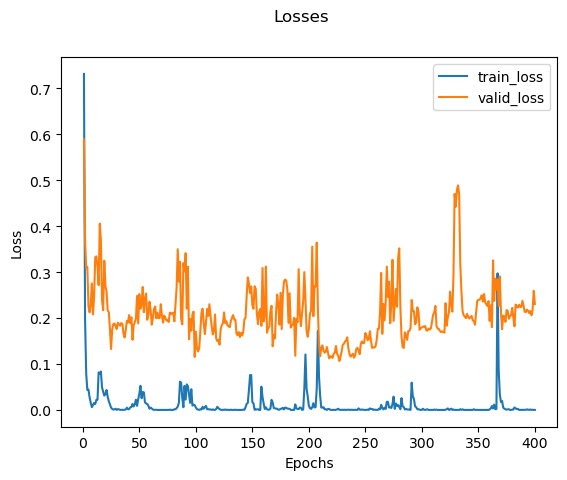

In [22]:
plt.suptitle('Losses')
plt.plot(range(1,1+epochs),train_losses, label='train_loss')
plt.plot(range(1,1+epochs),valid_losses,label='valid_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Getting anchor encodings

In [23]:
def get_encoding_csv(model,anc_img_names):
    anc_img_names_arr=np.array(anc_img_names)
    encodings=[]
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A=io.imread(d_dir+i)
            A=torch.from_numpy(A).permute(2,0,1)/255.0
            A=A.to(device)
            A_enc=model(A.unsqueeze(0)) # adding batchsize
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        encodings=np.array(encodings)
        encodings=pd.DataFrame(encodings)
        df_enc=pd.concat([anc_img_names,encodings],axis=1)
    
    return df_enc    

In [24]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
df_enc=get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 97.52it/s]


In [25]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1420_c5s3_052165_01.jpg,0.353541,1.592970,-0.901738,-0.687896,-1.241509,-0.502580,-0.561516,-0.511053,1.508046,...,1.651643,-0.786088,-0.889690,0.270894,-1.116461,-0.489876,-0.469201,0.421487,1.183205,-0.737541
1,1420_c3s3_061978_03.jpg,0.401743,1.500845,-0.784824,-0.578187,-1.257625,-0.555354,-0.513588,-0.593606,1.591613,...,1.369165,-0.729151,-0.805753,0.273625,-1.091748,-0.533459,-0.513586,0.530891,1.364749,-0.703484
2,1420_c5s3_062565_05.jpg,0.340855,1.445087,-0.845430,-0.466133,-1.163332,-0.587364,-0.583136,-0.678538,1.485753,...,1.228023,-0.709660,-0.768290,0.190412,-1.086650,-0.497321,-0.547982,0.469317,1.203297,-0.614335
3,1420_c6s3_085592_04.jpg,0.297546,1.342976,-0.953871,-0.337918,-0.950894,-0.456590,-0.636669,-0.440583,1.190457,...,1.361014,-0.902309,-0.714512,0.072969,-0.999895,-0.360414,-0.459160,0.277740,0.812119,-0.576957
4,0663_c5s3_085987_03.jpg,0.641517,0.555489,0.141757,0.115501,-1.124547,-0.846818,-0.933658,-1.253955,0.928510,...,0.920254,0.340387,-0.707310,0.922741,-0.559044,-0.411765,-0.965114,0.212658,0.954884,-0.342570


# Inference 

In [26]:
def euclidean_dist(img_enc,anc_enc_arr):
    dist=np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr).T))
    return dist

In [27]:
idx=57
img_name=df_enc['Anchor'].iloc[idx]
img_path=d_dir+img_name

img=io.imread(img_path)
img=torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
    img=img.to(device)
    img_enc=model(img.unsqueeze(0))
    img_enc=img_enc.detach().cpu().numpy()

In [28]:
anc_enc_arr=df_enc.iloc[:,1:].to_numpy()
anc_img_names=df_enc['Anchor']

In [29]:
distance=[]
for i in range(anc_enc_arr.shape[0]):
    dist=euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
    distance=np.append(distance,dist)

In [30]:
closest_distance=np.argsort(distance)

/opt/conda/lib/python3.10/site-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


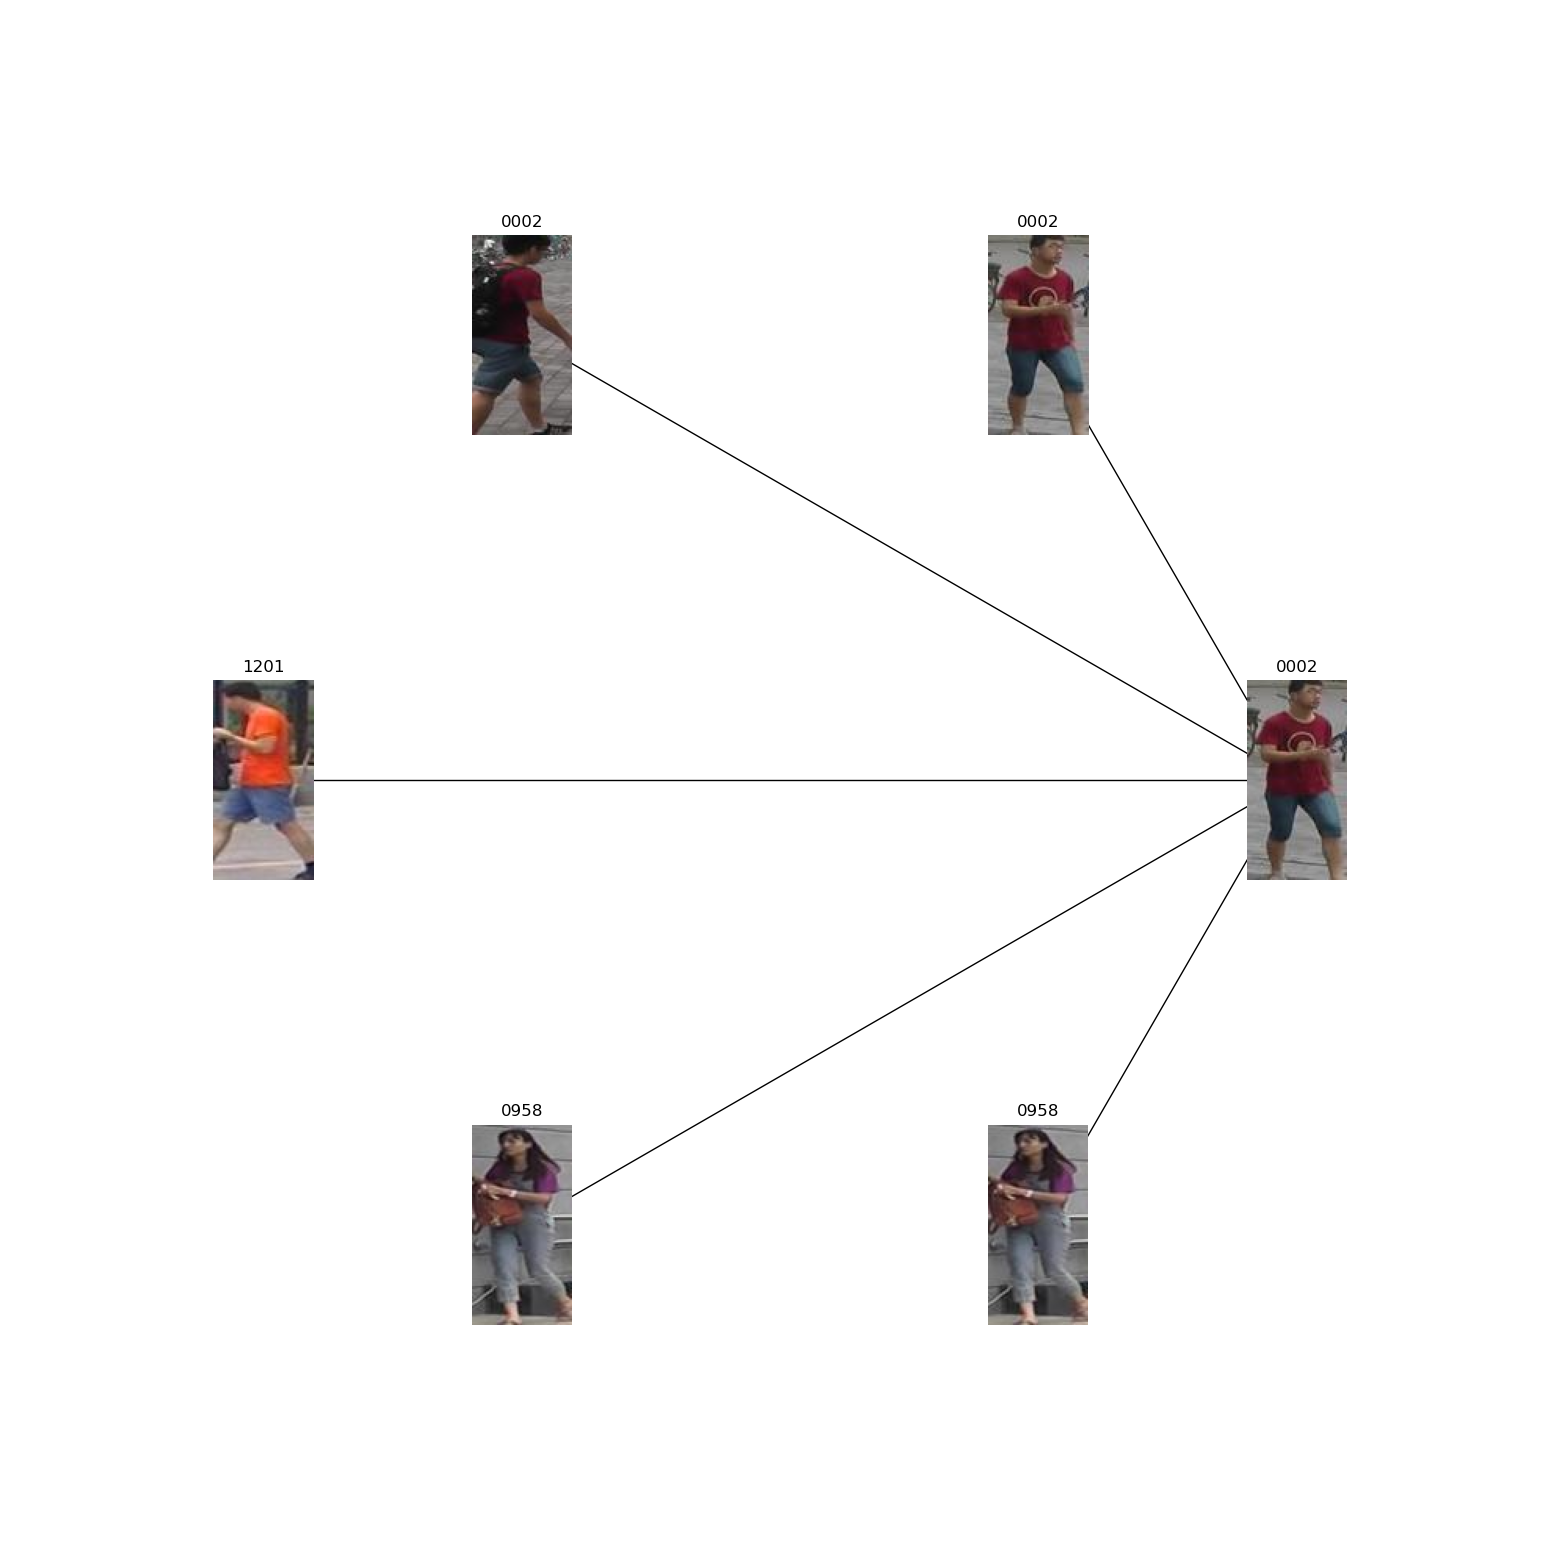

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names,d_dir,img,img_path,closest_distance,distance,no_of_closest=5)